# **Updated population density of the LA city neighborhood councils.**
    
### Evaluates the populataion, area (in square miles) and population density of the 99 Neighborhood councils (NCs). 

In [1]:
import os
import webbrowser
from pyproj import Geod
import geopandas as gpd
import numpy as np
import pandas as pd
import folium

In [2]:
# Path to the directory.
DIR = pwd

# Accessing the Census 2020 data. The geoemtry column in the shapely file- polygon geometry
# includes a series of latitude and longitude coordinate pairs that encloses an area.
census_2020 = gpd.read_file(
    os.path.join(DIR, "tl_2020_06037_tract20/tl_2020_06037_tract20.shp")
)

# Subsetting the columns of interest.
census_2020 = census_2020[
    ["TRACTCE20", "GEOID20", "INTPTLAT20", "INTPTLON20", "geometry"]
]
census_2020.head()

,TRACTCE20,GEOID20,INTPTLAT20,INTPTLON20,geometry
0,101110,06037101110,+34.2594737,-118.2929869,"POLYGON ((-118.30229 34.25870, -118.30091 34.2..."
1,101122,06037101122,+34.2677213,-118.2901465,"POLYGON ((-118.30334 34.27371, -118.30330 34.2..."
2,101220,06037101220,+34.2516083,-118.2816328,"POLYGON ((-118.28592 34.25227, -118.28592 34.2..."
3,101221,06037101221,+34.2543290,-118.2925767,"POLYGON ((-118.29945 34.25598, -118.29792 34.2..."
4,101222,06037101222,+34.2513519,-118.2885261,"POLYGON ((-118.29434 34.25233, -118.29318 34.2..."


In [3]:
# Reading the LA NC shape file.
la_nc = gpd.read_file(
    os.path.join(DIR, "neighborhood_councils/neighborhood_councils.shp")
)
la_nc.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,SERVICE_RE,geometry
0,1,ARLETA NC,http://www.arletanc.org/,http://empowerla.org/ANC,ANC@EmpowerLA.org,213-978-1551,6,2002-10-22,ARLETA NC,navigatela/reports/nc_reports.cfm?id=6,REGION 1 - NORTH EAST VALLEY,"POLYGON ((-118.44305 34.26328, -118.44303 34.2..."
1,2,ARROYO SECO NC,http://www.asnc.us/,http://empowerla.org/ASNC,ASNC@EmpowerLA.org,213-978-1551,42,2002-10-02,ARROYO SECO NC,navigatela/reports/nc_reports.cfm?id=42,REGION 8 - NORTH EAST LA,"POLYGON ((-118.19567 34.08613, -118.19568 34.0..."
2,3,ARTS DISTRICT LITTLE TOKYO NC,http://www.hcncla.org/,http://empowerla.org/HCNC,HCNC@EmpowerLA.org,213-978-1551,46,2002-04-27,ARTS DISTRICT LITTLE TOKYO NC,navigatela/reports/nc_reports.cfm?id=46,REGION 6 - CENTRAL 2,"POLYGON ((-118.23151 34.05348, -118.23141 34.0..."
3,4,ATWATER VILLAGE NC,http://www.atwatervillage.org/,http://empowerla.org/AVNC,AVNC@EmpowerLA.org,213-978-1551,37,2003-02-11,ATWATER VILLAGE NC,navigatela/reports/nc_reports.cfm?id=37,REGION 7 - EAST,"POLYGON ((-118.25279 34.10833, -118.25292 34.1..."
4,5,BEL AIR-BEVERLY CREST NC,http://babcnc.org/,http://empowerla.org/BABCNC,BABCNC@EmpowerLA.org,213-978-1551,64,2002-10-08,BEL AIR-BEVERLY CREST NC,navigatela/reports/nc_reports.cfm?id=64,REGION 11 - WEST LA,"POLYGON ((-118.36574 34.09948, -118.36575 34.0..."


In [4]:
# ACS demographics data.
acs_demographics = pd.read_csv(os.path.join(DIR, "acs_census_tract_la.csv"))

# Cleaning the GEO_ID column to be consistent with the GEOID20 coumn in census_2020 dataframe.
acs_demographics["GEO_ID"] = acs_demographics["GEO_ID"].str.replace("1400000US", "")

# Rename GEO_ID as GEOID20.
acs_demographics = acs_demographics.rename(
    columns={"GEO_ID": "GEOID20", "Total population": "population"}
)
acs_demographics.head()

,NAME,state,county,tract,GEOID20,population
0,"Census Tract 1997, Los Angeles County, California",6,37,199700,06037199700,3006
1,"Census Tract 1998.01, Los Angeles County, Cali...",6,37,199801,06037199801,3618
2,"Census Tract 1998.02, Los Angeles County, Cali...",6,37,199802,06037199802,2419
3,"Census Tract 1999, Los Angeles County, California",6,37,199900,06037199900,2687
4,"Census Tract 2011.10, Los Angeles County, Cali...",6,37,201110,06037201110,2203


In [5]:
# Taking a subset of the acs_demographics dataframe.
acs_demographics_subset = acs_demographics[["GEOID20", "population"]]

# Making sure that the crs- coordinate reference system for census_2020 is the same
# as that of the la_nc using the to_crs() # method. This will allow the spatial
# merging of both the geopandas dataframes.
census_2020 = census_2020.to_crs(la_nc.crs)

# Spatial overlap of the la_nc and census_2020 data.
census_nc = gpd.overlay(census_2020, la_nc, how="intersection")

census_nc = census_nc[
    ["TRACTCE20", "GEOID20", "NAME", "NC_ID", "INTPTLAT20", "INTPTLON20", "geometry"]
]
print("Number of rows in census_nc: ", census_nc.shape[0])

Number of rows in census_nc:  2108


In [6]:
# Let us take a look at the spatially merged data:
census_nc.head()

,TRACTCE20,GEOID20,NAME,NC_ID,INTPTLAT20,INTPTLON20,geometry
0,101110,06037101110,SUNLAND-TUJUNGA NC,10,+34.2594737,-118.2929869,"POLYGON ((-118.30229 34.25870, -118.30091 34.2..."
1,101122,06037101122,SUNLAND-TUJUNGA NC,10,+34.2677213,-118.2901465,"POLYGON ((-118.30334 34.27371, -118.30330 34.2..."
2,101220,06037101220,SUNLAND-TUJUNGA NC,10,+34.2516083,-118.2816328,"POLYGON ((-118.28592 34.25227, -118.28592 34.2..."
3,101221,06037101221,SUNLAND-TUJUNGA NC,10,+34.2543290,-118.2925767,"POLYGON ((-118.29945 34.25598, -118.29792 34.2..."
4,101222,06037101222,SUNLAND-TUJUNGA NC,10,+34.2513519,-118.2885261,"POLYGON ((-118.29434 34.25233, -118.29318 34.2..."


In [7]:
# Merging the census_nc and acs_demographics_subset.
tracts_nc_demographics = pd.merge(census_nc, acs_demographics_subset, on="GEOID20")
tracts_nc_demographics.head()

,TRACTCE20,GEOID20,NAME,NC_ID,INTPTLAT20,INTPTLON20,geometry,population
0,101110,06037101110,SUNLAND-TUJUNGA NC,10,+34.2594737,-118.2929869,"POLYGON ((-118.30229 34.25870, -118.30091 34.2...",3923
1,101122,06037101122,SUNLAND-TUJUNGA NC,10,+34.2677213,-118.2901465,"POLYGON ((-118.30334 34.27371, -118.30330 34.2...",4119
2,101122,06037101122,FOOTHILL TRAILS DISTRICT NC,9,+34.2677213,-118.2901465,"POLYGON ((-118.29785 34.27778, -118.29783 34.2...",4119
3,101220,06037101220,SUNLAND-TUJUNGA NC,10,+34.2516083,-118.2816328,"POLYGON ((-118.28592 34.25227, -118.28592 34.2...",3775
4,101221,06037101221,SUNLAND-TUJUNGA NC,10,+34.2543290,-118.2925767,"POLYGON ((-118.29945 34.25598, -118.29792 34.2...",3787


### Displaying the duplicate entries- census tracts intersecting more than 1 Neighborhood councils

In [8]:
df_duplicate = census_nc[census_nc.GEOID20.duplicated(keep=False)]
df_duplicate.sort_values(by=["GEOID20"]).head(15)

,TRACTCE20,GEOID20,NAME,NC_ID,INTPTLAT20,INTPTLON20,geometry
1,101122,06037101122,SUNLAND-TUJUNGA NC,10,+34.2677213,-118.2901465,"POLYGON ((-118.30334 34.27371, -118.30330 34.2..."
17,101122,06037101122,FOOTHILL TRAILS DISTRICT NC,9,+34.2677213,-118.2901465,"POLYGON ((-118.29785 34.27778, -118.29783 34.2..."
5,101300,06037101300,SUNLAND-TUJUNGA NC,10,+34.2487777,-118.2709990,"POLYGON ((-118.27822 34.25068, -118.27822 34.2..."
18,101300,06037101300,FOOTHILL TRAILS DISTRICT NC,9,+34.2487777,-118.2709990,"POLYGON ((-118.26682 34.23124, -118.26695 34.2..."
6,101400,06037101400,SUNLAND-TUJUNGA NC,10,+34.2428521,-118.2941612,"POLYGON ((-118.32227 34.24961, -118.32212 34.2..."
19,101400,06037101400,FOOTHILL TRAILS DISTRICT NC,9,+34.2428521,-118.2941612,"POLYGON ((-118.32238 34.24963, -118.32227 34.2..."
42,102103,06037102103,SUN VALLEY AREA NC,8,+34.2250792,-118.3541880,"POLYGON ((-118.36533 34.22870, -118.36396 34.2..."
20,102103,06037102103,FOOTHILL TRAILS DISTRICT NC,9,+34.2250792,-118.3541880,"POLYGON ((-118.35739 34.22856, -118.35546 34.2..."
43,102104,06037102104,SUN VALLEY AREA NC,8,+34.2161873,-118.3453981,"POLYGON ((-118.35620 34.21971, -118.35594 34.2..."
21,102104,06037102104,FOOTHILL TRAILS DISTRICT NC,9,+34.2161873,-118.3453981,"MULTIPOLYGON (((-118.34413 34.21387, -118.3441..."


In [9]:
df_duplicate.shape[0]

1475

### Out of 2108 rows, 1475 rows are duplicate. 

### Here is a map of NCs and census tracts. Zoom in and toggle between NC and census tracts to see that some of the NCs share the census tracts with their neighbors. 

### Here is a link to the [map](https://exquisite-squirrel-d3afcc.netlify.app/). I am using netlify to deploy the interactive map. 

In [10]:
m = la_nc.explore(
    column ='NAME',  # Make choropleth based on 'NC name' column.
    name='NC Regions', 
    tooltip='NAME',  # Show 'NC name' value in tooltip (on hover).
    color="black",  # Use black color on all points.
    popup=True,  # Show all values in popup (on click).
    tiles="openstreetmap",  # Use "openstreetmap" tiles.
    cmap="Set1",  # Use "Set1" matplotlib colormap.
    style_kwds=dict(color="black"),  # Use black outline.
    legend=False
     ) 
census_nc.explore(
    m=m,
    column='TRACTCE20',  # Make choropleth based on 'TRACTCE20' column.
    name='Census tracts', 
    tooltip='TRACTCE20',  # Show 'TRACTCE20' value in tooltip (on hover).
    color="red",  # Use red color on all points.
    popup=True,  # Show all values in popup (on click).
    tiles="openstreetmap",  # Use "openstreetmap" tiles.
    cmap="Set1",  # Use "Set1" matplotlib colormap.
    style_kwds=dict(color="black"),  # Use black outline.
    legend=False
     )
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Water Color').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl().add_to(m)
m.save('census_plus_NC.html')
webbrowser.open('census_plus_NC.html')

True

### A zoomed in picture of the NC map is shown below, illustrating examples when NCs share census tracts with its neighbors. These are just few of such cases. INTPTLAT20 and INTPTLON20 correspond to the latitude and the longitude of the internal points for each NC. From this figure, it can be seen that the census tract overlapping with more than 1 NC share the same INTPTLAT20 and INTPTLON20. 

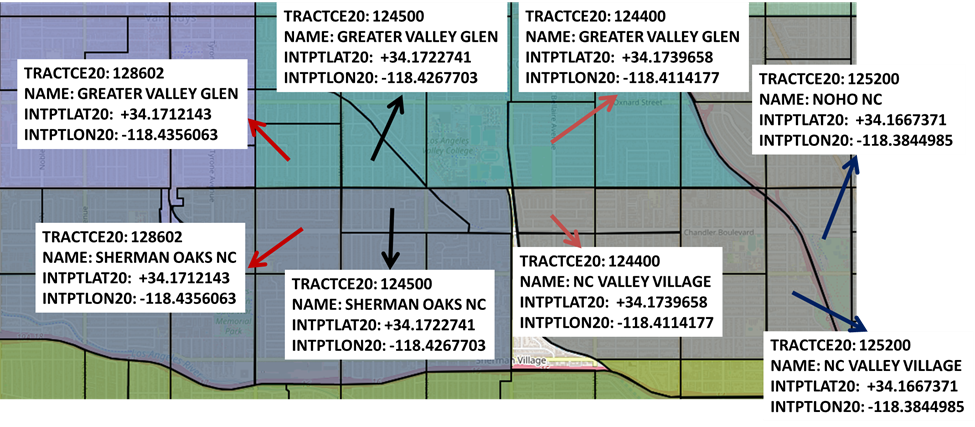

### Before moving forward, let us try to get the population of distinct census tracts without worrying about the proportion of NC areas intersected by census tracts. To do this, I will retain the first row of the duplicate data for the entire dataframe.

In [11]:
test = tracts_nc_demographics.groupby('TRACTCE20').first()
test.population.sum()

4534712

<div style="text-align: justify">  
    
### This number exactly matches with the one that I get using this [notebook](https://github.com/priyakalyan/Updated_NC_pop/blob/main/NC_pop_recent_no_filter.ipynb) where the population of NCs have been calculated using the same census tracts as in the dataframe tracts_nc_demographics. In this notebook, the sum of the population of all NCs at the tract level is inflated.
    
###  This implies that the census tracts that is being used in the calculation is wrong. This issue will be addressed here. But before going ahead, the next section will outline the methodology to calculate the area of census tracts intersecting multiple NCs.

### So here is a method to take care of cases where the census tract intersects more than 1 NCs. 

- **Find the area for each entry in census dataframe.** 
- **Group the census dataframe by 'TRACTCE20' and then find sum of the area- this gives you the total area of each census       tract.** 
- **Next, find the percentage of area of the census tract intersecting different NCs.** 
- **Use this information to find the percentage of population for each census tract.**
- **Then find the total population by grouping them by NCs.** 
- **It should be noted that we are making an assumption of uniform distrubution of people within a census tract.** 

### Defining a [function](https://github.com/hackforla/access-the-data-workshop-311-analysis/blob/main/notebooks/NC-population-density.ipynb) to compute the area in square miles (area (sq_miles)).

In [12]:
geod = Geod(ellps='WGS84') 

def area_sq_miles(geo):
    """ Returns area in square miles for the input geo, where geo is the polygon 
    (boundary feature) for each NC given by the geometry column.
    """
    area_sq_meters = abs(geod.geometry_area_perimeter(geo)[0])
    return (area_sq_meters * 3.86102e-7)

In [13]:
# Add the area column.
tracts_nc_demographics = pd.merge(census_nc, acs_demographics_subset, on="GEOID20")
tracts_nc_demographics["area"] = tracts_nc_demographics.apply(
    lambda row: area_sq_miles(row.geometry), axis=1
)
tracts_nc_demographics[["NC_ID", "NAME", "TRACTCE20", "population", "area"]].head(10)

,NC_ID,NAME,TRACTCE20,population,area
0,10,SUNLAND-TUJUNGA NC,101110,3923,0.441083
1,10,SUNLAND-TUJUNGA NC,101122,4119,1.020872
2,9,FOOTHILL TRAILS DISTRICT NC,101122,4119,0.000038
3,10,SUNLAND-TUJUNGA NC,101220,3775,0.269841
4,10,SUNLAND-TUJUNGA NC,101221,3787,0.136748
5,10,SUNLAND-TUJUNGA NC,101222,2717,0.114484
6,10,SUNLAND-TUJUNGA NC,101300,3741,0.993003
7,9,FOOTHILL TRAILS DISTRICT NC,101300,3741,0.002387
8,10,SUNLAND-TUJUNGA NC,101400,3246,2.414663
9,9,FOOTHILL TRAILS DISTRICT NC,101400,3246,0.021664


In [14]:
# Adding the total_area column by grouping tracts_nc_demographics by TRACTCE20 
# and summing up the area for each census tract.
tracts_nc_test = tracts_nc_demographics.groupby("TRACTCE20", as_index=False).agg(
    {
        "NC_ID": "first",
        "NAME": "first",
        "geometry": "first",
        "INTPTLAT20": "first",
        "INTPTLON20": "first",
        "NAME": "first",
        "GEOID20": "first",
        "area": sum,
    }
)
tracts_nc_test.rename(columns={"area": "total_area"}, inplace=True)
tracts_nc_test = tracts_nc_test[["TRACTCE20", "total_area"]]

In [15]:
# Let us merge the tracts_nc_demographics and tracts_nc_test dataframes.
tracts_nc_perc = pd.merge(tracts_nc_demographics, tracts_nc_test, on="TRACTCE20")
tracts_nc_perc.head()

,TRACTCE20,GEOID20,NAME,NC_ID,INTPTLAT20,INTPTLON20,geometry,population,area,total_area
0,101110,06037101110,SUNLAND-TUJUNGA NC,10,+34.2594737,-118.2929869,"POLYGON ((-118.30229 34.25870, -118.30091 34.2...",3923,0.441083,0.441083
1,101122,06037101122,SUNLAND-TUJUNGA NC,10,+34.2677213,-118.2901465,"POLYGON ((-118.30334 34.27371, -118.30330 34.2...",4119,1.020872,1.020910
2,101122,06037101122,FOOTHILL TRAILS DISTRICT NC,9,+34.2677213,-118.2901465,"POLYGON ((-118.29785 34.27778, -118.29783 34.2...",4119,0.000038,1.020910
3,101220,06037101220,SUNLAND-TUJUNGA NC,10,+34.2516083,-118.2816328,"POLYGON ((-118.28592 34.25227, -118.28592 34.2...",3775,0.269841,0.269841
4,101221,06037101221,SUNLAND-TUJUNGA NC,10,+34.2543290,-118.2925767,"POLYGON ((-118.29945 34.25598, -118.29792 34.2...",3787,0.136748,0.136748


In [16]:
# Evaluating the percentage of the intersecting areas (area_perc):
tracts_nc_perc["area_perc"] = tracts_nc_perc["area"] / tracts_nc_perc["total_area"]

# Adding the percentage of population column.
tracts_nc_perc["total_population"] = (
    tracts_nc_perc["population"] * tracts_nc_perc["area_perc"]
)

# Rounding the population number:
tracts_nc_perc["total_population"] = tracts_nc_perc["total_population"].apply(np.floor)

# Converting the population to integer type.
tracts_nc_perc["total_population"] = tracts_nc_perc["total_population"].astype(int)

tracts_nc_perc[
    [
        "TRACTCE20",
        "NAME",
        "NC_ID",
        "population",
        "area",
        "area_perc",
        "total_area",
        "total_population",
    ]
].head(15)

,TRACTCE20,NAME,NC_ID,population,area,area_perc,total_area,total_population
0,101110,SUNLAND-TUJUNGA NC,10,3923,0.441083,1.000000,0.441083,3923
1,101122,SUNLAND-TUJUNGA NC,10,4119,1.020872,0.999963,1.020910,4118
2,101122,FOOTHILL TRAILS DISTRICT NC,9,4119,0.000038,0.000037,1.020910,0
3,101220,SUNLAND-TUJUNGA NC,10,3775,0.269841,1.000000,0.269841,3775
4,101221,SUNLAND-TUJUNGA NC,10,3787,0.136748,1.000000,0.136748,3787
5,101222,SUNLAND-TUJUNGA NC,10,2717,0.114484,1.000000,0.114484,2717
6,101300,SUNLAND-TUJUNGA NC,10,3741,0.993003,0.997602,0.995390,3732
7,101300,FOOTHILL TRAILS DISTRICT NC,9,3741,0.002387,0.002398,0.995390,8
8,101400,SUNLAND-TUJUNGA NC,10,3246,2.414663,0.991108,2.436327,3217
9,101400,FOOTHILL TRAILS DISTRICT NC,9,3246,0.021664,0.008892,2.436327,28


<div style="text-align: justify">  
    
### I will be incorporating the area filter and the population filter to skim out the values that were causing the population of the NCs to inflate. 

### Let us take a look at the NC- Atwater Village. 

In [17]:
# NC- Atwater village.
tracts_nc_perc[tracts_nc_perc["NAME"] == "ATWATER VILLAGE NC"][
    [
        "TRACTCE20",
        "NAME",
        "NC_ID",
        "population",
        "area",
        "area_perc",
        "total_area",
        "total_population",
    ]
]

,TRACTCE20,NAME,NC_ID,population,area,area_perc,total_area,total_population
811,189703,ATWATER VILLAGE NC,37,1880,0.043906,0.029314,1.497769,55
833,311601,ATWATER VILLAGE NC,37,2608,0.000209,0.149092,0.001404,388
837,311700,ATWATER VILLAGE NC,37,5966,0.004878,0.322874,0.015109,1926
841,980009,ATWATER VILLAGE NC,37,5,6.816197,0.312739,21.795157,1
973,187102,ATWATER VILLAGE NC,37,4376,0.340444,0.402493,0.845840,1761
984,187101,ATWATER VILLAGE NC,37,3213,0.302714,0.995004,0.304234,3196
986,187200,ATWATER VILLAGE NC,37,3324,0.011649,0.031713,0.367315,105
990,187300,ATWATER VILLAGE NC,37,3715,0.004740,0.010301,0.460138,38
994,188100,ATWATER VILLAGE NC,37,3960,0.813095,1.000000,0.813095,3960
995,188201,ATWATER VILLAGE NC,37,3262,0.019628,0.058066,0.338025,189


### Look at the census tracts 301601, 301602, 301702, 311801. When I looked at the map, these were the tracts belonging to the neighboring city- Glendale. These tracts obviously do not belong to Atwater Village NC. The total area of these tracts are extremely small, but the area_perc for some of these tracts - 1 and so the whole population is taken into account and thus this will result in a higher population value than the expected one. So, I am adding the area filter- total_area(sq_miles) >= 0.01. 
    
### Similarly, some of the population value is so small, but the cumulative effect can result in an exaggerated population number. Therefore, I am going to add the population filter here. The [minimum population](https://www2.census.gov/geo/pdfs/education/CensusTracts.pdf) of a whole census tract is 1200. Since we are dealing with proportional areas and sometimes, a census tract intersects 2 NCs in 30% to 70% ratio and so I want to be reasonable with the population filter- 1000 (we do not want to undercount too). 

In [18]:
# Filtering out total_area < 0.01 square miles.
tracts_nc_perc_filter = tracts_nc_perc[tracts_nc_perc["total_area"] >= 0.01]
tracts_nc_perc_filter.head()

,TRACTCE20,GEOID20,NAME,NC_ID,INTPTLAT20,INTPTLON20,geometry,population,area,total_area,area_perc,total_population
0,101110,06037101110,SUNLAND-TUJUNGA NC,10,+34.2594737,-118.2929869,"POLYGON ((-118.30229 34.25870, -118.30091 34.2...",3923,0.441083,0.441083,1.000000,3923
1,101122,06037101122,SUNLAND-TUJUNGA NC,10,+34.2677213,-118.2901465,"POLYGON ((-118.30334 34.27371, -118.30330 34.2...",4119,1.020872,1.020910,0.999963,4118
2,101122,06037101122,FOOTHILL TRAILS DISTRICT NC,9,+34.2677213,-118.2901465,"POLYGON ((-118.29785 34.27778, -118.29783 34.2...",4119,0.000038,1.020910,0.000037,0
3,101220,06037101220,SUNLAND-TUJUNGA NC,10,+34.2516083,-118.2816328,"POLYGON ((-118.28592 34.25227, -118.28592 34.2...",3775,0.269841,0.269841,1.000000,3775
4,101221,06037101221,SUNLAND-TUJUNGA NC,10,+34.2543290,-118.2925767,"POLYGON ((-118.29945 34.25598, -118.29792 34.2...",3787,0.136748,0.136748,1.000000,3787


In [19]:
# Removing the rows with population value < 1000.
tracts_nc_perc_filter = tracts_nc_perc_filter[
    tracts_nc_perc_filter["total_population"] >= 1000
]
tracts_nc_perc_filter.shape[0]

1172

In [20]:
# Summming up the population of each NCs.
tracts_nc_pop = tracts_nc_perc_filter.groupby("NAME", as_index=False).agg(
    {"NC_ID": "first", "NAME": "first", "total_population": sum}
)
tracts_nc_pop["total_population"] = tracts_nc_pop["total_population"].astype(int)
tracts_nc_pop.head(50)

,NC_ID,NAME,total_population
0,6,ARLETA NC,35585
1,42,ARROYO SECO NC,19479
2,46,ARTS DISTRICT LITTLE TOKYO NC,4153
3,37,ATWATER VILLAGE NC,14665
4,64,BEL AIR-BEVERLY CREST NC,24732
5,50,BOYLE HEIGHTS NC,87817
6,13,CANOGA PARK NC,54184
7,110,CENTRAL ALAMEDA NC,30219
8,32,CENTRAL HOLLYWOOD NC,18204
9,95,CENTRAL SAN PEDRO NC,29244


In [21]:
tracts_nc_pop.total_population.sum()

3825667

<div style="text-align: justify">  
    
### This number is close to the [Census Bureau](https://www.census.gov/quickfacts/losangelescitycalifornia?) value- 3,849,297. Now that we have the population of each NC, let us move on to getting the area and finally the updated population density of the neighborhood councils.      

In [22]:
# Grouping the original tracts_nc_demographics dataframe by NAME and then summing up
# the total area- this gives the area of each neighborhood council. Very important note
# here- groupby function works when trying to aggregate dataframes but for spatial data,
# we can aggregate the geometry features using dissolve function.

tracts_nc_area = tracts_nc_demographics.dissolve(
    by="NAME", as_index=False, aggfunc=({"NC_ID": "first", "area": sum})
)

# Gathering all the columns of interest.
tracts_nc_final = tracts_nc_area.join(tracts_nc_pop["total_population"])
tracts_nc_final["pop_density"] = (
    tracts_nc_final["total_population"] / tracts_nc_final["area"]
)

# Rearranging the columns.
tracts_nc_final = tracts_nc_final[
    ["NAME", "geometry", "NC_ID", "total_population", "area", "pop_density"]
]
tracts_nc_final.head(15)

,NAME,geometry,NC_ID,total_population,area,pop_density
0,ARLETA NC,"POLYGON ((-118.41010 34.23309, -118.41034 34.2...",6,35585,3.284868,10833.007723
1,ARROYO SECO NC,"POLYGON ((-118.18576 34.09293, -118.18576 34.0...",42,19479,3.063327,6358.773341
2,ARTS DISTRICT LITTLE TOKYO NC,"POLYGON ((-118.22877 34.04155, -118.22827 34.0...",46,4153,0.879216,4723.528997
3,ATWATER VILLAGE NC,"POLYGON ((-118.25399 34.10816, -118.25424 34.1...",37,14665,8.748450,1676.296980
4,BEL AIR-BEVERLY CREST NC,"POLYGON ((-118.46573 34.07325, -118.46581 34.0...",64,24732,17.038756,1451.514436
5,BOYLE HEIGHTS NC,"POLYGON ((-118.20504 34.01263, -118.20504 34.0...",50,87817,5.735881,15310.116685
6,CANOGA PARK NC,"POLYGON ((-118.58846 34.19524, -118.58846 34.1...",13,54184,3.689892,14684.440778
7,CENTRAL ALAMEDA NC,"POLYGON ((-118.23777 33.98933, -118.23777 33.9...",110,30219,1.358014,22252.346382
8,CENTRAL HOLLYWOOD NC,"POLYGON ((-118.32445 34.08712, -118.32445 34.0...",32,18204,1.229127,14810.517707
9,CENTRAL SAN PEDRO NC,"POLYGON ((-118.28794 33.73151, -118.28795 33.7...",95,29244,2.438025,11994.957379


### Here is a plot of tracts_nc_final dataframe with the population, population density and area popping up for each NCs. I am posting the link to this [map](https://effervescent-profiterole-8fd074.netlify.app/).

In [23]:
m1 = tracts_nc_final.explore(
    column= 'NAME',  # Make choropleth based on 'NC name' column.
    name='NC Regions', 
    tooltip='NAME',  # Show 'NC name' value in tooltip (on hover).
    color="black",  # Use red color on all points.
    popup=True,  # Show all values in popup (on click).
    tiles="openstreetmap",  # Use "openstreetmap" tiles.
    cmap="Set1",  # Use "Set1" matplotlib colormap.
    style_kwds=dict(color="black"),  # Use black outline.
    legend=False
     )
folium.TileLayer('Stamen Terrain').add_to(m1)
folium.TileLayer('Stamen Toner').add_to(m1)
folium.TileLayer('Stamen Water Color').add_to(m1)
folium.TileLayer('cartodbpositron').add_to(m1)
folium.TileLayer('cartodbdark_matter').add_to(m1)
folium.LayerControl().add_to(m1)
m1.save('tracts_nc_final.html')
webbrowser.open('tracts_nc_final.html')

True

In [24]:
tracts_nc_final.head()

,NAME,geometry,NC_ID,total_population,area,pop_density
0,ARLETA NC,"POLYGON ((-118.41010 34.23309, -118.41034 34.2...",6,35585,3.284868,10833.007723
1,ARROYO SECO NC,"POLYGON ((-118.18576 34.09293, -118.18576 34.0...",42,19479,3.063327,6358.773341
2,ARTS DISTRICT LITTLE TOKYO NC,"POLYGON ((-118.22877 34.04155, -118.22827 34.0...",46,4153,0.879216,4723.528997
3,ATWATER VILLAGE NC,"POLYGON ((-118.25399 34.10816, -118.25424 34.1...",37,14665,8.748450,1676.296980
4,BEL AIR-BEVERLY CREST NC,"POLYGON ((-118.46573 34.07325, -118.46581 34.0...",64,24732,17.038756,1451.514436


In [25]:
# Save the dataframe as a csv file after dropping the geometry column.
tracts_nc_final= tracts_nc_final.drop(['geometry'], axis=1)
tracts_nc_final.to_csv('tracts_nc_final.csv')